### Import & Data load

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm
import os
import seaborn as sns
import re

_dir = '_20'
_month = '07'
_file_ls = [i for i in os.listdir(_dir) if re.split('/|_',_dir)[-1]+_month in re.split('_', i)]
freez2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'freezer' in i][0]))
suth2005 = pd.read_csv(os.path.join(_dir, [i for i in _file_ls if 'suth' in i][0]))


freez2005.columns
freez2005.columns = ['freezer_id', 'gw_time', 'status', 'fan_run', 'fan_trip',
       'freez_run', 'freez_trip', 'defrost', 'ctrl_mode', 'ctrl_operation',
       'operation', 'run_time', 'insert_dt']

suth2005.columns
suth2005.columns = ['sensor_id', 'gw_time', 'status', 'color_list', 'avg_temperature',
       'avg_humidity', 'temperature', 'humidity', 'battery', 'available',
       'insert_dt']

%matplotlib inline

### SCM 창고(19) sensor, freezer 추출, Column 선별, Type 재설정

In [102]:
# No. 19
sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

df_sensor = pd.DataFrame()
df_freezer = pd.DataFrame()

for elem in sensor_id:
    df_sensor = pd.concat([df_sensor, suth2005[suth2005['sensor_id'] == elem]])
    print("sensor id {}의 데이터 개수: {}".format(elem, len(suth2005[suth2005['sensor_id'] == elem])))
for elem in freezer_id:
    df_freezer = pd.concat([df_freezer, freez2005[freez2005['freezer_id'] == elem]])
    print("freezer id {}의 데이터 개수: {}".format(elem, len(df_freezer[df_freezer['freezer_id'] == elem])))

df_sensor.sort_values(by = ['sensor_id', 'gw_time'])
df_freezer.sort_values(by = ['freezer_id', 'gw_time'])

print('sensor: ',df_sensor['sensor_id'].unique())
print('freezer: ', df_freezer['freezer_id'].unique())

df_sensor = df_sensor.drop(columns = ['color_list','insert_dt'])
df_freezer = df_freezer.drop(columns= ['insert_dt'])

df_sensor['gw_time'] = pd.to_datetime(df_sensor['gw_time'])
df_freezer['gw_time'] = pd.to_datetime(df_freezer['gw_time'])


sensor id 329의 데이터 개수: 88599
sensor id 332의 데이터 개수: 88599
sensor id 335의 데이터 개수: 88599
freezer id 344의 데이터 개수: 90050
freezer id 362의 데이터 개수: 90050
freezer id 368의 데이터 개수: 90050
sensor:  [329 332 335]
freezer:  [344 362 368]


# Sensor 결측치 처리
- sensor의 available == 0 일 때, 결측치 발생
- 결측치는 모두 -99999로 되어있음

In [103]:
df_sensor.isnull().sum()

sensor_id          0
gw_time            0
status             0
avg_temperature    0
avg_humidity       0
temperature        0
humidity           0
battery            0
available          0
dtype: int64

In [104]:
condition = df_sensor.values == -99999
df_sensor[condition] = np.nan

# Position

In [105]:
# sensor_pos = {
#     "290": {"x": 2, "y": 3},
#     "293": {"x": 5, "y": 3},
#     "296": {"x": 3, "y": 8},
#     "299": {"x": 4, "y": 14},
#     "302": {"x": 4, "y": 5}
# }
# freezer_pos = {
#     "308": {"x": 2, "y": 1},
#     "314": {"x": 6, "y": 1},
#     "320": {"x": 8, "y": 10},
#     "326": {"x": 4, "y": 17}
# }

# sensor_pos = pd.DataFrame(sensor_pos).T
# freezer_pos = pd.DataFrame(freezer_pos).T

# sensor_pos = sensor_pos.reset_index()
# freezer_pos = freezer_pos.reset_index()
# pos = pd.concat([sensor_pos,freezer_pos])


In [106]:
# no. 19
sensor_pos = {
    "329": {"x": 16, "y": 5},
    "332": {"x": 10, "y": 5},
    "335": {"x": 4, "y": 5},
    "338": {"x": 18, "y": 1}
}
freezer_pos = {
    "344": {"x": 16, "y": 0},
    "344-1": {"x": 14, "y": 0},
    "362": {"x": 11, "y": 0},
    "362-1": {"x": 8, "y": 0},
    "368": {"x": 4, "y": 0},
    "368-1": {"x": 2, "y": 0}
}
door_pos = {
    "door": {"x": 4, "y": 9}
}

sensor_pos = pd.DataFrame(sensor_pos).T
sensor_pos['type'] = ['sensor']*len(sensor_pos)
freezer_pos = pd.DataFrame(freezer_pos).T
freezer_pos['type'] = ['freezer']*len(freezer_pos)
door_pos = pd.DataFrame(door_pos).T
door_pos['type']= ['door']*len(door_pos)
sensor_pos = sensor_pos.reset_index()
freezer_pos = freezer_pos.reset_index()
door_pos = door_pos.reset_index()
pos = pd.concat([sensor_pos,freezer_pos,door_pos])


In [107]:
def display_position(pos):
    plt.figure(figsize = (12,10))
    sns.scatterplot(
        x = 'x', 
        y = 'y', 
        data = pos, 
        hue = 'index', 
        style='type',
        s = 70
        )
    # sensor
    for _id in sensor_id:
        x = sensor_pos[sensor_pos['index'] == str(_id)]['x']
        y = sensor_pos[sensor_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(sensor)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 
    
    # # freezer
    for _id in freezer_id:
        x = freezer_pos[freezer_pos['index'] == str(_id)]['x']
        y = freezer_pos[freezer_pos['index'] == str(_id)]['y']
        plt.annotate(str(_id)+'(freezer)', xy = (x,y), xytext=(x, y-1), fontsize = 10, ha = 'center', arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10)) 

    plt.annotate('door', xy=(pos[pos['type'] == 'door']['x'], pos[pos['type'] == 'door']['y']), xytext=(pos[pos['type'] == 'door']['x'],pos[pos['type'] == 'door']['y']-1),
                fontsize=10, ha='center',
                arrowprops=dict(facecolor='blue', width=1, shrink=0.1, headwidth=10))
            

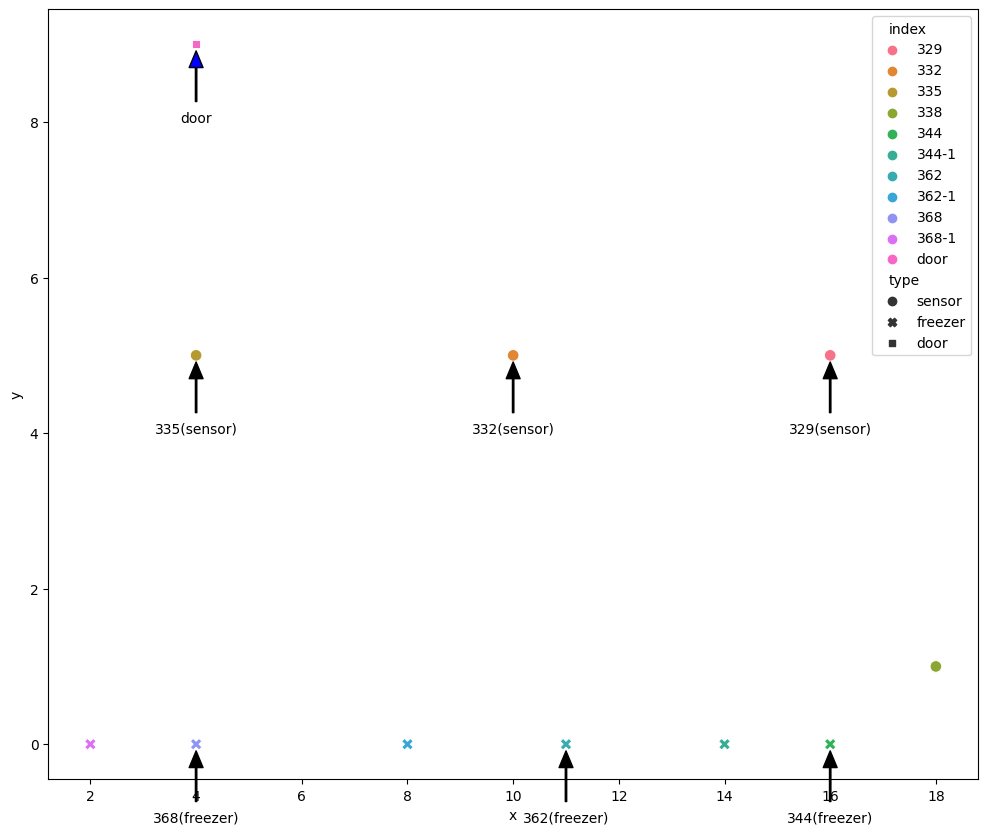

In [108]:
display_position(pos)

# Mapping

## melt id to columns

In [109]:
df0 = df_freezer.copy()['gw_time']
for _id in df_freezer['freezer_id'].unique():
    df_tmp = df_freezer[df_freezer['freezer_id'] == _id]
    df_tmp.reset_index(drop = True)
    df_tmp.drop(columns= ['freezer_id'], inplace= True)
    df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_freezer.columns if x not in ['freezer_id','gw_time']]
    df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

melted_freezer = df0

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\1092712872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\1092712872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['freezer_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\1092712872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [110]:
df0 = df_sensor.copy()['gw_time']
for _id in df_sensor['sensor_id'].unique():
    df_tmp = df_sensor[df_sensor['sensor_id'] == _id]
    df_tmp.reset_index(drop = True)
    df_tmp.drop(columns= ['sensor_id'], inplace= True)
    df_tmp.columns = ['gw_time']+[x+'_'+str(_id) for x in df_sensor.columns if x not in ['sensor_id','gw_time']]
    df0 = pd.merge(df0, df_tmp, on = 'gw_time', how = 'outer')

melted_sensor = df0

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\1020320345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['sensor_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\1020320345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(columns= ['sensor_id'], inplace= True)
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\1020320345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [111]:
melted_df = pd.merge_asof(
    left=melted_sensor.sort_values(by="gw_time"),
    right=melted_freezer.sort_values(by="gw_time"),
    on="gw_time",
    direction="forward",
    tolerance=pd.Timedelta("30 second"),
    allow_exact_matches=False,
    suffixes=("_freezer", "_sensor"),
)
melted_df.drop_duplicates(inplace= True, ignore_index= True)
melted_df.index = melted_df['gw_time']


In [112]:
null_indexs  = melted_df[melted_df['freez_run_344'].isnull()].index
null_columns = melted_df[melted_df['freez_run_344'].isnull()].columns

In [113]:
for col in null_columns[1:]:
    melted_df[col] = melted_df[col].interpolate(method='time')

melted_df.isnull().sum().sum()

0

## delta temperture (dT)

In [114]:
# melted_df['dT_335'] = melted_df['temperature_335'] - melted_df.temperature_335.shift(1).fillna(melted_df['temperature_335'][0])
# melted_df['dT_332'] = melted_df['temperature_332'] - melted_df.temperature_332.shift(1).fillna(melted_df['temperature_332'][0])
# melted_df['dT_329'] = melted_df['temperature_329'] - melted_df.temperature_329.shift(1).fillna(melted_df['temperature_329'][0])

for _id in sensor_id:
    melted_df['dT_'+str(_id)] =  melted_df['temperature_'+str(_id)] - melted_df['temperature_'+str(_id)].shift(1).fillna(melted_df['temperature_'+str(_id)][0])


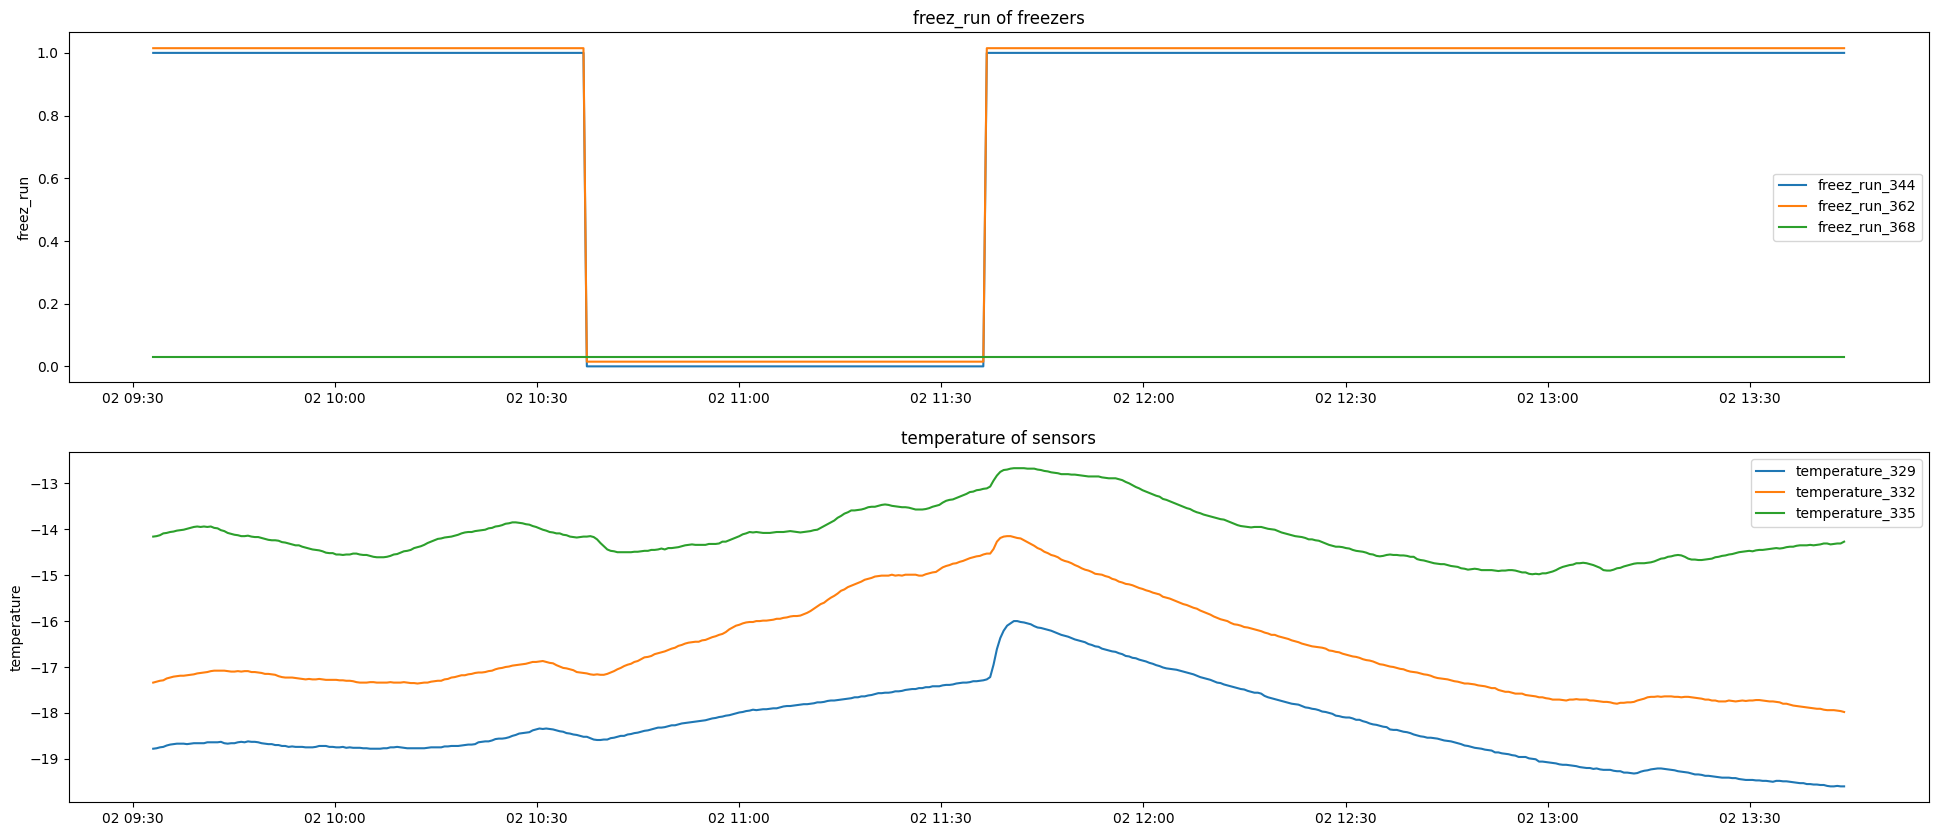

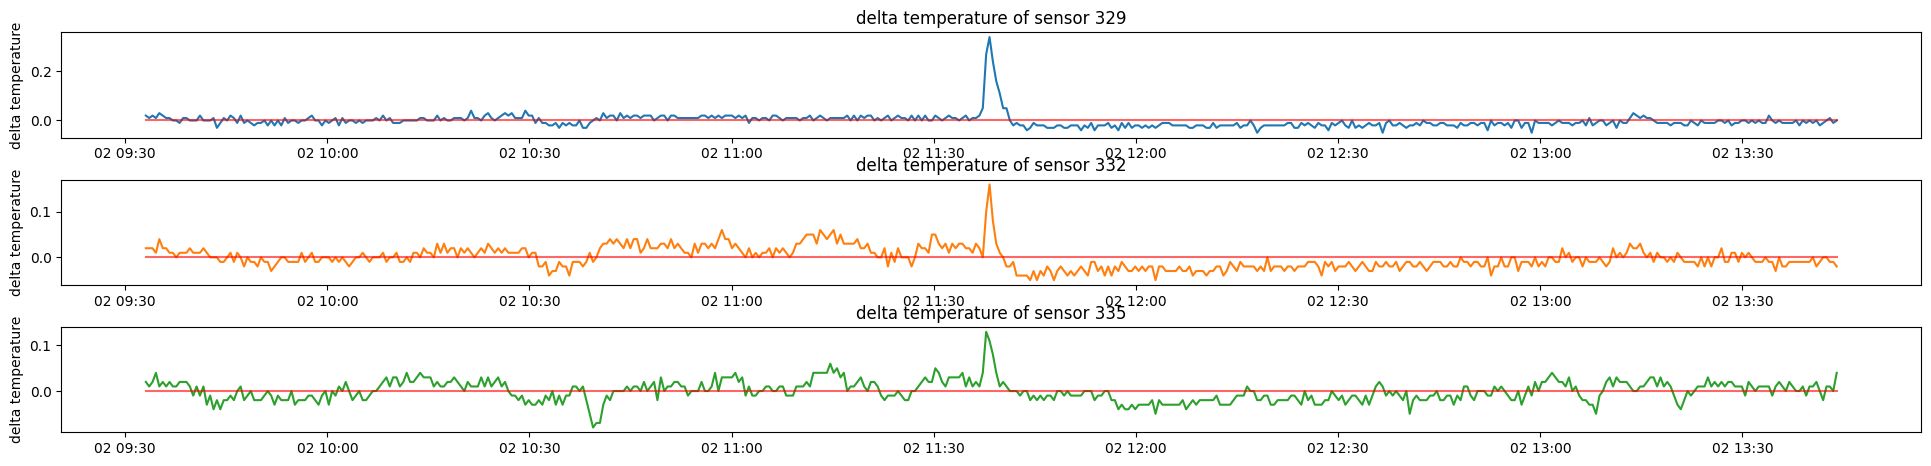

In [115]:
test_figure = melted_df[4000:4500]
plt.figure(figsize = (24,10))

plt.subplot(2,1,1)
plt.title("freez_run of freezers")
w = 0
for _id in freezer_id:
    plt.plot(test_figure['gw_time'],test_figure['fan_run'+'_'+str(_id)]+w, label = 'freez_run'+'_'+str(_id),alpha = 1)
    w+= 0.015
plt.ylabel('freez_run')
plt.legend()

plt.subplot(2,1,2)
plt.title('temperature of sensors')
for _id in sensor_id:
    plt.plot(test_figure['gw_time'],test_figure['temperature'+'_'+str(_id)], label = 'temperature'+'_'+str(_id),alpha = 1)
plt.ylabel('temperature')
plt.legend()
plt.show()

i = 1
colors = ['tab:blue','tab:orange','tab:green']
plt.figure(figsize = (24,5))
for _id in sensor_id:
    plt.subplot(3,1,i)
    plt.title('delta temperature of sensor '+str(_id), loc= 'center')
    plt.plot(test_figure['gw_time'],test_figure['dT'+'_'+str(_id)], label = 'dT'+'_'+str(_id),alpha = 1, color = colors[i-1])
    plt.plot(test_figure['gw_time'], [0]*len(test_figure), color = 'r', alpha = 0.6)
    plt.ylabel('delta temperature')
    i+=1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

# 간단한 모델 만들기

In [116]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [117]:
df = melted_df.copy()
df.isnull().sum().sum()

0

In [118]:
for elem in sensor_id:
    df['temperature_'+str(elem)+'_prime'] = df['temperature_'+str(elem)].shift(1)

import random
for col in ['operation_'+ str(_id) for _id in freezer_id]:
    random_list = []
    for i in range(len(df)):
        random_list.append(random.randint(0,1))
    df[col+'_random'] = random_list
    df[col+'_zero'] = [0]*len(df)
    df[col+'_one'] = [1]*len(df)

df = df.dropna()

In [119]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scale_cols =['dT_'+str(_id) for _id in sensor_id]+['temperature_'+str(_id) for _id in sensor_id]+['humidity_'+str(_id) for _id in sensor_id]
# for col in scale_cols:
#     df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

In [120]:
TEST_SIZE = 8000
train_raw = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]
train_raw.shape, test.shape

((80598, 67), (8000, 67))

In [121]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols =['dT_'+str(_id) for _id in sensor_id]+['temperature_'+str(_id) for _id in sensor_id]+['humidity_'+str(_id) for _id in sensor_id] + ['temperature_'+str(_id)+'_prime' for _id in sensor_id]
for col in scale_cols:
    train_raw[col] = scaler.fit_transform(train_raw[col].values.reshape(-1,1))
    test[col] = scaler.transform(test[col].values.reshape(-1,1))

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\2132141817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_raw[col] = scaler.fit_transform(train_raw[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\2132141817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler.transform(test[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_8312\2132141817.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [122]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [123]:
# feature_cols = ['fan_run_344',
#  'fan_run_362',
#  'fan_run_368',
#  'fan_trip_344',
#  'fan_trip_362',
#  'fan_trip_368',
#  'freez_run_344',
#  'freez_run_362',
#  'freez_run_368',
#  'freez_trip_344',
#  'freez_trip_362',
#  'freez_trip_368',
#  'defrost_344',
#  'defrost_362',
#  'defrost_368',
#  'ctrl_mode_344',
#  'ctrl_mode_362',
#  'ctrl_mode_368',
#  'ctrl_operation_344',
#  'ctrl_operation_362',
#  'ctrl_operation_368',
#  'operation_344',
#  'operation_362',
#  'operation_368','temperature_329_prime']
# feature_cols = [
#  'operation_344',
#  'operation_362',
#  'operation_368','temperature_329_prime']

feature_cols = [
 'operation_344_random',
 'operation_362_random',
 'operation_368_random','temperature_329_prime']
# feature_cols = ['temperature_329_prime']

label_cols = ['temperature_329']


In [124]:
train_feature = train_raw[feature_cols]
train_label = train_raw[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = False)

x_train.shape, x_valid.shape
# ((57676, 20, 21), (14419, 20, 21))

((64462, 20, 4), (16116, 20, 4))

In [125]:
test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((7980, 20, 4), (7980, 1))

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=False)
          )
model.add(Dense(1))

In [128]:
np.save('train_feature.npy', train_feature)
np.save('train_label.npy', train_label)

In [88]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = './tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=256,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint],
                    shuffle = False)

Epoch 1/100
250/252 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 1: val_loss improved from inf to 0.00012, saving model to .\tmp_checkpoint.h5
252/252 [==============================] - 5s 10ms/step - loss: 0.0021 - val_loss: 1.1633e-04
Epoch 2/100
246/252 [============================>.] - ETA: 0s - loss: 1.5747e-04
Epoch 2: val_loss improved from 0.00012 to 0.00007, saving model to .\tmp_checkpoint.h5
252/252 [==============================] - 2s 9ms/step - loss: 1.5522e-04 - val_loss: 7.3129e-05
Epoch 3/100
250/252 [============================>.] - ETA: 0s - loss: 1.5415e-04
Epoch 3: val_loss improved from 0.00007 to 0.00005, saving model to .\tmp_checkpoint.h5
252/252 [==============================] - 2s 9ms/step - loss: 1.5396e-04 - val_loss: 5.2337e-05
Epoch 4/100
247/252 [============================>.] - ETA: 0s - loss: 1.5667e-04
Epoch 4: val_loss improved from 0.00005 to 0.00004, saving model to .\tmp_checkpoint.h5
252/252 [==============================]

KeyboardInterrupt: 

In [ ]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

250/250 [==============================] - 1s 3ms/step


MSE:  8.485901521147833e-06
MAE:  0.0021237177298260184


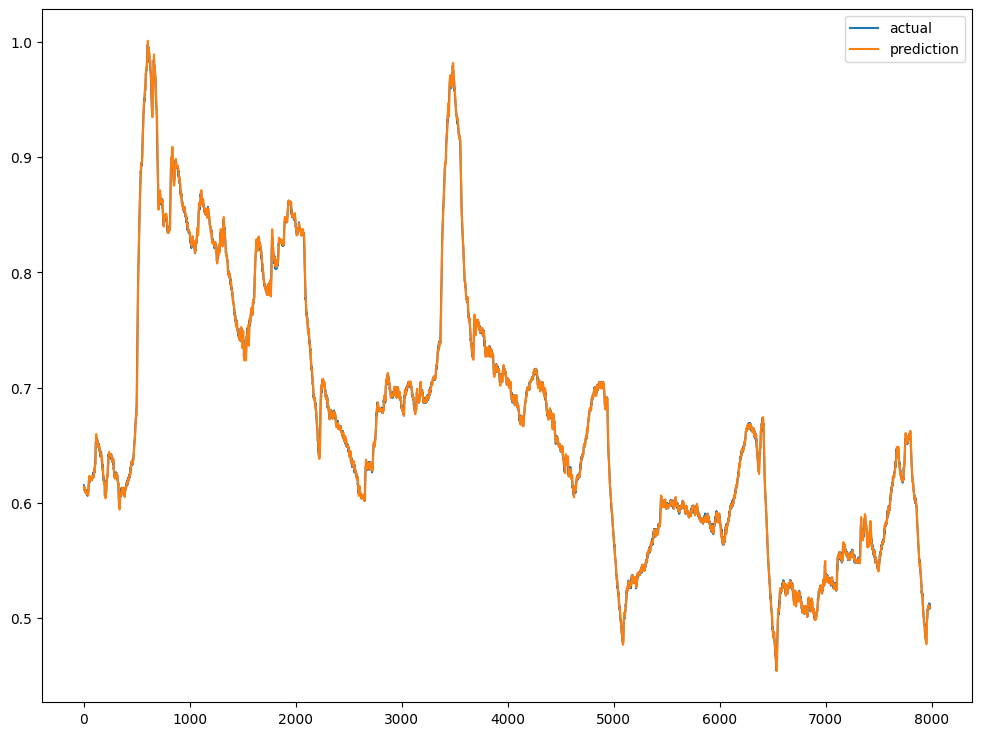

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("MSE: ", mean_squared_error(test_label, pred))
print("MAE: ", mean_absolute_error(test_label, pred))
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
_temp_scaler = MinMaxScaler()
_temp_scaler.fit(train_raw['temperature_329'].values.reshape(-1,1))


MinMaxScaler()

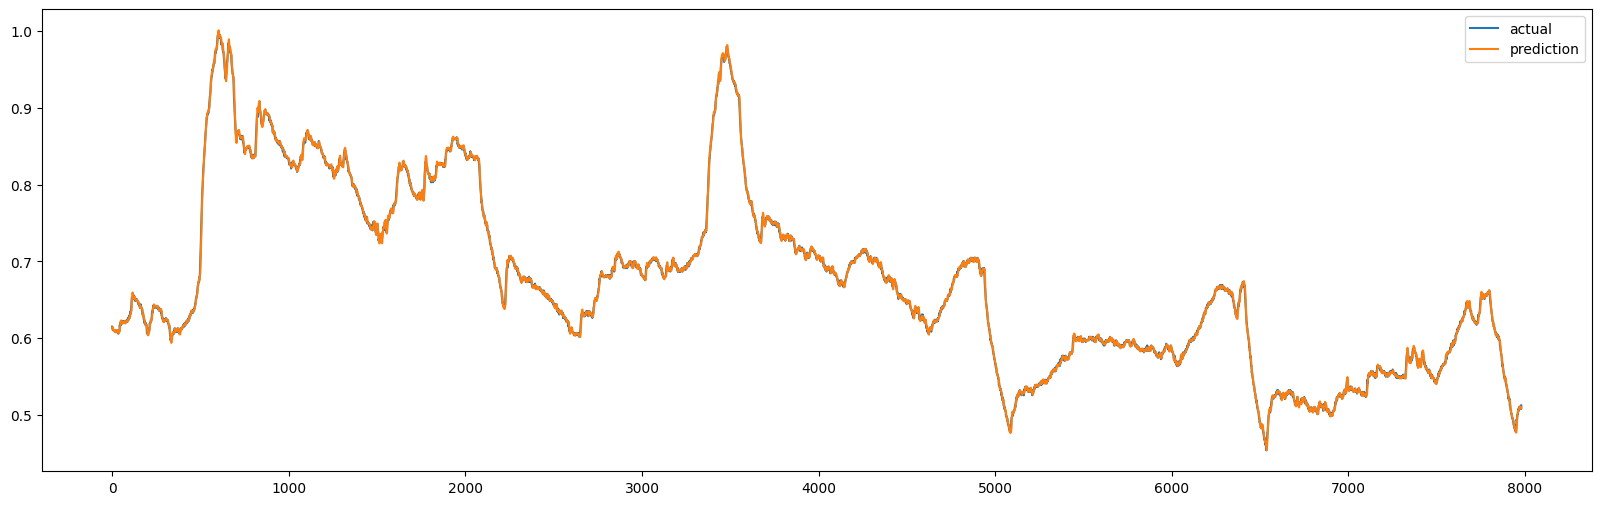

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(_temp_scaler.inverse_transform(test_label), label='actual')
plt.plot(_temp_scaler.inverse_transform(pred), label='prediction')
plt.legend()
plt.show()

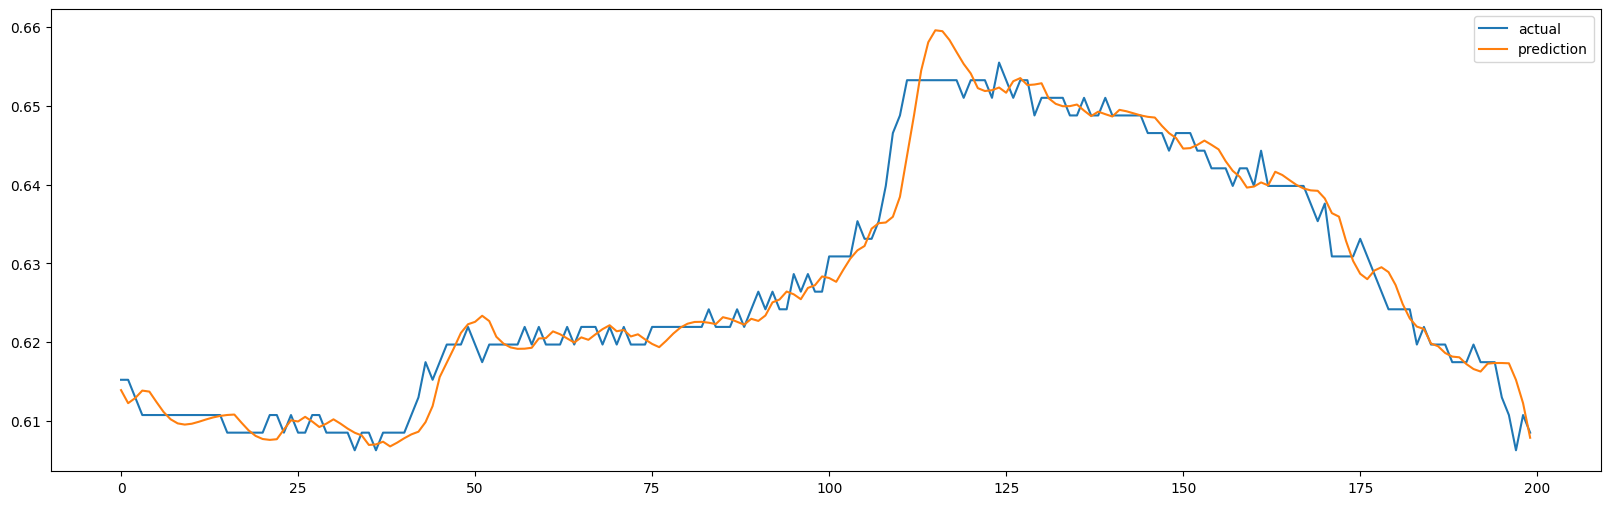

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(_temp_scaler.inverse_transform(test_label[:200]), label='actual')
plt.plot(_temp_scaler.inverse_transform(pred[:200]), label='prediction')
plt.legend()
plt.show()

In [ ]:
train_raw[label_cols]

,temperature_329
gw_time,
2021-02-01 00:00:34,0.203579
2021-02-01 00:01:04,0.203579
2021-02-01 00:01:35,0.203579
2021-02-01 00:02:05,0.205817
2021-02-01 00:02:35,0.203579
...,...
2021-02-26 04:51:39,0.617450
2021-02-26 04:52:09,0.615213
2021-02-26 04:52:39,0.615213
